In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 01:  Data Import
 * Import data
 * Feature processing
 * Train-test split and mean encoding

I do not do extensive data exploration but instead use others' insights from various
Kaggle projects, especially:
* https://www.kaggle.com/code/ricardocolindres/loan-default-prediction-loan-parameter-optimizer

I am also not going to use all the features I could.  I want to focus on NAICS, and so I don't do a lot with bank, franchise, or geography.

Because I am focused on NAICS I am going to drop rows with missing NAICS

*This script takes about 1 minute on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

In [4]:
from sklearn.preprocessing import OneHotEncoder

## Import Data

##### Loans Data - See README.md

In [5]:
sba_loans = pd.read_csv(setup.input_path,  dtype=setup.input_dtypes, parse_dates = setup.input_dates,
                        converters = setup.input_converters)

/var/folders/h9/4b0yxscx221gvjqy2cqp_kyh0000gn/T/ipykernel_10933/3842615021.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sba_loans = pd.read_csv(setup.input_path,  dtype=setup.input_dtypes, parse_dates = setup.input_dates,
/var/folders/h9/4b0yxscx221gvjqy2cqp_kyh0000gn/T/ipykernel_10933/3842615021.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sba_loans = pd.read_csv(setup.input_path,  dtype=setup.input_dtypes, parse_dates = setup.input_dates,
/var/folders/h9/4b0yxscx221gvjqy2cqp_kyh0000gn/T/ipykernel_10933/3842615021.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a fo

In [6]:
sba_loans.dtypes

LoanNr_ChkDgt                object
Name                         object
City                         object
State                        object
Zip                          object
Bank                         object
BankState                    object
NAICS                        object
ApprovalDate         datetime64[ns]
ApprovalFY                   object
Term                          int64
NoEmp                         int64
NewExist                     object
CreateJob                     int64
RetainedJob                   int64
FranchiseCode                object
UrbanRural                   object
RevLineCr                    object
LowDoc                       object
ChgOffDate           datetime64[ns]
DisbursementDate     datetime64[ns]
DisbursementGross           float64
BalanceGross                float64
MIS_Status                   object
ChgOffPrinGr                float64
GrAppv                      float64
SBA_Appv                    float64
dtype: object

In [7]:
sba_loans.select_dtypes(np.datetime64).describe()

,ApprovalDate,ChgOffDate,DisbursementDate
count,899164,162699,896796
mean,2001-06-04 11:57:49.414700416,2008-07-02 12:56:30.968597760,2001-09-24 03:38:57.328891136
min,1974-01-09 00:00:00,1988-10-03 00:00:00,1974-01-07 00:00:00
25%,1996-11-22 00:00:00,2007-09-04 00:00:00,1997-05-31 00:00:00
50%,2002-09-27 00:00:00,2009-12-04 00:00:00,2002-12-31 00:00:00
75%,2006-01-20 00:00:00,2011-03-16 00:00:00,2006-03-31 00:00:00
max,2073-12-20 00:00:00,2026-10-22 00:00:00,2073-12-24 00:00:00


##### NAICS map

In [8]:
naics_map = pd.read_csv('naics/naics_map.csv', dtype='str', encoding='latin1' ) \
    .rename(columns={'Sector': 'NAICS_sector',
                     'Description': 'NAICS_sector_desc'})

In [9]:
naics_map[['NAICS_sector', 'NAICS_sector_desc']] = naics_map[['NAICS_sector', 'NAICS_sector_desc']] \
    .apply(lambda x: x.astype('category'))

In [10]:
naics_map.head(5)

,NAICS_sector,NAICS_2,NAICS_sector_desc
0,11,11,"Agriculture, Forestry, Fishing and Hunting"
1,21,21,"Mining, Quarrying, and Oil and Gas Extraction"
2,22,22,Utilities
3,23,23,Construction
4,31-33,31,Manufacturing


##### All NAICS Descriptions (2007)

In [11]:
naics_desc = pd.read_csv('naics/naics_2007.csv', dtype='str', encoding='latin1' ) \
    .rename(columns={'INDEX ITEM DESCRIPTION': 'NAICS07_desc'})

In [12]:
naics_desc.sample(4)

,NAICS07,NAICS07_desc
14781,481111,"Air passenger carriers, scheduled"
6983,325414,Antivenoms manufacturing
3450,313249,Hand knitting lace or warp fabric products
13638,423910,Archery equipment merchant wholesalers


In [13]:
naics_desc.to_parquet(Path(setup.temp_path).joinpath('01_DATA_naics07_descriptions.parquet'))

## Process Target

##### Create the target feature (0/1) that indicates a default

In [14]:
sba_loans['MIS_Status'].value_counts()

MIS_Status
P I F     739609
CHGOFF    157558
Name: count, dtype: int64

In [15]:
sba_loans['MIS_Status'].value_counts(normalize=True, dropna=False)

MIS_Status
P I F     0.822552
CHGOFF    0.175227
NaN       0.002221
Name: proportion, dtype: float64

In [16]:
# Defaults are fairly common.  About 1/6 of loans default

In [17]:
# Check the nulls
sba_loans[sba_loans['MIS_Status'].isna()].sample(3)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
823365,8835951004,BANTAS AND MOMS GROCERY,PARIS,KY,40361,"TRADITIONAL BANK, INC.",KY,0,1979-08-30,1979,...,N,N,1992-08-25,NaT,0.0,0.0,NaN,408.0,42000.0,31500.0
153101,2115765006,JILLIAN WENTWORTH DBA THE HAIR,DANSVILLE,NY,14437,CITIZENS BANK NATL ASSOC,RI,812112,2006-11-09,2007,...,N,N,NaT,2007-03-31,2000.0,0.0,NaN,0.0,2000.0,1000.0
98036,1726775003,"THE EDGE GROUP, LLC",CARMEL,IN,46032,CITIZENS BANK NATL ASSOC,RI,561720,2006-03-23,2006,...,Y,N,NaT,2006-04-30,2654.0,0.0,NaN,0.0,1000.0,500.0


In [18]:
sba_loans[sba_loans['MIS_Status'].isna()][['ChgOffPrinGr', 'BalanceGross', 'ChgOffDate']].describe()

,ChgOffPrinGr,BalanceGross,ChgOffDate
count,1997.000000,1997.0,261
mean,2758.911367,0.0,2003-03-19 06:15:10.344827648
min,0.000000,0.0,1988-12-12 00:00:00
25%,0.000000,0.0,1992-09-15 00:00:00
50%,0.000000,0.0,2008-05-05 00:00:00
75%,0.000000,0.0,2010-02-20 00:00:00
max,650543.000000,0.0,2014-08-27 00:00:00
std,27531.777037,0.0,NaN


In [19]:
sba_loans[sba_loans['MIS_Status'].isna()]['ChgOffDate'].isna().value_counts()

ChgOffDate
True     1736
False     261
Name: count, dtype: int64

In [20]:
# The loans with unknown MIS Status are a small count, most don't have charge-off dates but some do
# Drop these rows as they are ambiguous and small volume
sba_loans = sba_loans[~sba_loans['MIS_Status'].isna()]

In [21]:
# Create a binary feature for the remaining loans
sba_loans['target'] = np.where(sba_loans['MIS_Status'] == 'P I F', 0, 1)

In [22]:
sba_loans['target'].value_counts(dropna=False, normalize=True)

target
0    0.824383
1    0.175617
Name: proportion, dtype: float64

## Predictor Features - Basic Processing

##### Convert approval year to a date

In [23]:
sba_loans['ApprovalFY'] = sba_loans['ApprovalFY'].str[0:4].astype('int')
sba_loans['ApprovalFY'].describe()

count    897167.000000
mean       2001.139677
std           5.912461
min        1966.000000
25%        1997.000000
50%        2002.000000
75%        2006.000000
max        2014.000000
Name: ApprovalFY, dtype: float64

In [24]:
sba_loans['ApprovalFY'].isna().value_counts()

ApprovalFY
False    897167
Name: count, dtype: int64

##### Express SBA guaranteed amount as a fraction

In [25]:
sba_loans['guaranteed_fract'] = sba_loans['SBA_Appv']/sba_loans['GrAppv']

##### Convert Y/N binary columns

In [26]:
# Function to convert 'Y','N' columns
def convert_yn(ser):
    cond = [ser.isna(), ser.str.lower() == 'y', ser.str.lower() == 'n']
    choice =[np.nan, 1, 0]
    return np.select(cond, choice, np.nan)

In [27]:
sba_loans['LowDoc'].value_counts(dropna=False)

LowDoc
N      780997
Y      110171
NaN      2578
0        1490
C         758
S         603
A         495
R          74
1           1
Name: count, dtype: int64

In [28]:
sba_loans['RevLineCr'].value_counts().head(5)

RevLineCr
N    419252
0    257431
Y    200660
T     15239
1        23
Name: count, dtype: int64

In [29]:
# There are some strange values in both fields, but I will follow the documentation and assume that the Y/N mean true or false.
# I will let the other values become NA

In [30]:
sba_loans['RevLineCr'] = convert_yn(sba_loans['RevLineCr'])
sba_loans['RevLineCr'].value_counts(dropna=False)

RevLineCr
0.0    419252
NaN    277255
1.0    200660
Name: count, dtype: int64

In [31]:
sba_loans['LowDoc'] = convert_yn(sba_loans['LowDoc'])
sba_loans['LowDoc'].value_counts(dropna=False)

LowDoc
0.0    780997
1.0    110171
NaN      5999
Name: count, dtype: int64

##### New/existing business

In [32]:
sba_loans['NewExist'].value_counts(dropna=False)

NewExist
1      643446
2      252559
0        1028
NaN       134
Name: count, dtype: int64

In [33]:
cond = [sba_loans['NewExist'].isna(), sba_loans['NewExist'] == '1', sba_loans['NewExist'] == '2']
choice = [np.nan, 0, 1]
sba_loans['new_business'] = np.select(cond, choice, np.nan)

In [34]:
sba_loans['new_business'].value_counts(dropna=False)

new_business
0.0    643446
1.0    252559
NaN      1162
Name: count, dtype: int64

##### Urban/Rural

In [35]:
sba_loans['UrbanRural'].value_counts(dropna=False)

UrbanRural
1    469281
0    322826
2    105060
Name: count, dtype: int64

In [36]:
cond = [sba_loans['UrbanRural'].isna(), sba_loans['UrbanRural'] == '1', sba_loans['UrbanRural'] == '2']
choice = [np.nan, 1, 0]
sba_loans['urban_flag'] = np.select(cond, choice, np.nan)

##### Franchise flag
Note we have a more detailed code, but just mark rows with no franchise info

In [37]:
sba_loans['FranchiseCode'].value_counts(dropna=False).head(5)

FranchiseCode
1        637395
0        208040
78760      3373
68020      1921
50564      1034
Name: count, dtype: int64

In [38]:
cond = [sba_loans['FranchiseCode'].isna(), sba_loans['FranchiseCode'].isin(['1', '0', '00000', '00001'])]
choice = [np.nan, 0]
sba_loans['franchise_flag'] = np.select(cond, choice, 1)

In [39]:
sba_loans['franchise_flag'].value_counts(dropna=False)

franchise_flag
0.0    845435
1.0     51732
Name: count, dtype: int64

## NAICS
I am most interested in this feature for this project.  I am going to add the NAICS sector feature here.  I will use both NAICS and NAICS sector information in my models.  

I use 2007 NAICS definitions as this data spans a range of timeframes, with median ~2009; however this one vintage may not perfectly reflect the data. See also https://www.census.gov/naics/?48967

Later I will mean encode NAICS (this is my usual approach to this field).  I also will one-hot encode as this is usual, and use a numeric form of NAICS to compare performance.  In this section I map the NAICS sector and create the numeric feature.  After train/test/validation split, I do the encodings.

Later I also will drop missing NAICS.  I don't do it here 

##### Descriptives and clean up

In [40]:
sba_loans['NAICS'].value_counts(dropna=False)

NAICS
0         201667
722110     27941
722211     19435
811111     14539
621210     14034
           ...  
212231         1
925120         1
524192         1
311351         1
333241         1
Name: count, Length: 1312, dtype: int64

In [41]:
# First things first those 0's have to go
sba_loans['NAICS'] = sba_loans['NAICS'].where(sba_loans['NAICS'] != '0', np.nan)
sba_loans['NAICS'].value_counts(dropna=False)

NAICS
NaN       201667
722110     27941
722211     19435
811111     14539
621210     14034
           ...  
212231         1
925120         1
524192         1
311351         1
333241         1
Name: count, Length: 1312, dtype: int64

In [42]:
# Length of remaining codes
sba_loans['NAICS'].str.len().value_counts()
# They all have the right number of digits!

NAICS
6.0    695500
Name: count, dtype: int64

In [43]:
# Distribution of counts - how many codes have just 1 company (not too many)
count_info  = sba_loans['NAICS'].value_counts(dropna=True)
(count_info == 1).value_counts()

count
False    1278
True       33
Name: count, dtype: int64

In [44]:
sba_loans['NAICS'].isna().value_counts()

NAICS
False    695500
True     201667
Name: count, dtype: int64

In [45]:
count_info.describe()

count     1311.000000
mean       530.511060
std       1503.077093
min          1.000000
25%         36.000000
50%        126.000000
75%        377.000000
max      27941.000000
Name: count, dtype: float64

In [46]:
cond  = [count_info == 1, count_info < 10, count_info < 50, count_info < 100,
         count_info < 1000, count_info < 10000]
choice = ['0001', '0002-0009', '0010-0049', '0050-0099', '0100-1000', '1000-9999']
count_cat = pd.Series(np.select(cond, choice, '10k+'))

In [47]:
count_cat.value_counts()

0100-1000    559
0010-0049    257
0050-0099    191
1000-9999    153
0002-0009    113
0001          33
10k+           5
Name: count, dtype: int64

In [48]:
# There are not so many very rare codes.  But about 50% have < 126 loans.  And there are some very common codes

##### Add the NAICS sector information

In [49]:
sba_loans['NAICS_2'] = sba_loans['NAICS'].str[0:2]

In [50]:
sba_loans = sba_loans \
    .drop(columns=['NAICS_sector', 'NAICS_sector_desc'], errors='ignore') \
    .merge(naics_map, on='NAICS_2', how='left')

In [51]:
sba_loans['NAICS_sector_desc'].value_counts()

NAICS_sector_desc
Retail Trade                                                                126975
Other Services (except Public Administration)                                72395
Professional, Scientific, and Technical Services                             67922
Manufacturing                                                                67903
Accommodation and Food Services                                              67511
Construction                                                                 66492
Health Care and Social Assistance                                            55264
Wholesale Trade                                                              48673
Administrative and Support and Waste Management and Remediation Services     32529
Transportation and Warehousing                                               22408
Arts, Entertainment, and Recreation                                          14616
Real Estate and Rental and Leasing                                   

In [52]:
# There are some slightly rare sectors, e.g. Public Administration

##### Add the numeric form of the NAICS featuresba_loans

In [53]:
sba_loans['NAICS_num']= sba_loans['NAICS'].astype('float')

In [54]:
sba_loans['NAICS_num'].describe()

count    695500.000000
mean     514102.946193
std      173375.659980
min      111110.000000
25%      423430.000000
50%      512110.000000
75%      621399.000000
max      928120.000000
Name: NAICS_num, dtype: float64

## Age of Loan

Older loans likely have very long terms (and therefore were designated as low risk).  Also loans in place for decades may be unlikely to default now.  In addition, I suspect many such loans will have NULL NAICS codes.  I will explore this.

In [55]:
sba_loans['missing_NAICS'] = np.where(sba_loans['NAICS'].isna(), 1, 0)

##### Missingness and loan age

In [56]:
sba_loans.groupby('missing_NAICS')['ApprovalFY'].agg(['median', 'mean', 'min', 'max'])

,median,mean,min,max
missing_NAICS,,,,
0,2004.0,2003.018242,1984,2014
1,1995.0,1994.660971,1966,2010


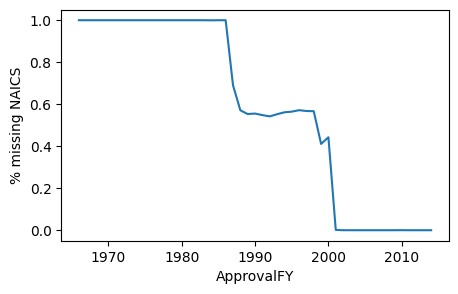

In [57]:
# Plot NAICS missingness
fig, ax = plt.subplots(figsize = (5, 3))
sba_loans.groupby('ApprovalFY')['missing_NAICS'].agg('mean').plot(ax = ax)
ax.set_ylabel('% missing NAICS')
plt.gcf().savefig(Path(setup.temp_path).joinpath('01_PLOT_loan_year_NAICS_missing.png'),bbox_inches='tight')

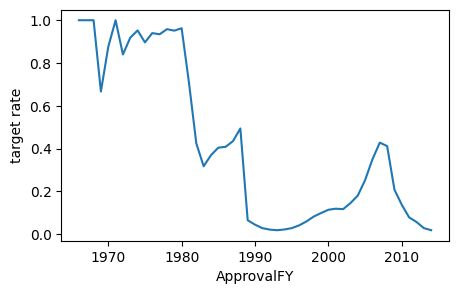

In [58]:
# Plot target rate
fig, ax = plt.subplots(figsize = (5, 3))
sba_loans.groupby('ApprovalFY')['target'].agg('mean').plot(ax = ax)
ax.set_ylabel('target rate')
plt.gcf().savefig(Path(setup.temp_path).joinpath('01_PLOT_loan_year_target_rate.png'),bbox_inches='tight')

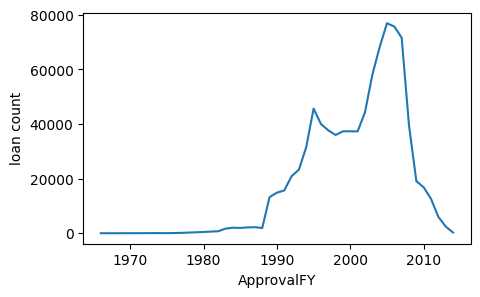

In [59]:
# Plot target rate
# Plot NAICS missingness
fig, ax = plt.subplots(figsize = (5, 3))
sba_loans.groupby('ApprovalFY')['target'].agg('count').plot(ax = ax)
ax.set_ylabel('loan count')
plt.gcf().savefig(Path(setup.temp_path).joinpath('01_PLOT_loan_year_counts.png'),bbox_inches='tight')

Loans prior to 1990 are rare and also have super high default rates, and often-null NAICS.  I think these loans are probably very different from more modern loans.  I am going to drop these.

I probably will not include the approval FY explicitly in my model, because new data could be drawn from future years.  However I expect that the model will still pick up on some over-time trends.  For example, it might correlate a missing NAICS with a higher default rate, due to confounding with age of loan.

At this point I also drop rows with missing NAICS

In [60]:
sba_loans = sba_loans[(sba_loans['ApprovalFY'] >= 1990) &
                     (sba_loans['missing_NAICS'] == 0)] \
    .drop(columns='missing_NAICS')

In [61]:
# Drop the "missing NAICS" feature
sba_loans['ApprovalFY'].describe()

count    688081.000000
mean       2003.172576
std           4.750860
min        1990.000000
25%        2001.000000
50%        2004.000000
75%        2006.000000
max        2014.000000
Name: ApprovalFY, dtype: float64

##### Save dataset so far

In [62]:
sba_loans.describe()

,ApprovalDate,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,...,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,target,guaranteed_fract,new_business,urban_flag,franchise_flag,NAICS_num
count,688081,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,457016.000000,683029.000000,144040,686207,...,688081.000000,6.880810e+05,6.880810e+05,6.880810e+05,688081.000000,688081.000000,687231.000000,551445.000000,688081.000000,688081.000000
mean,2003-06-08 19:41:48.344801920,2003.172576,102.479897,9.715318,2.169425,5.136857,0.425541,0.098445,2009-10-13 17:19:37.272979712,2003-09-17 10:43:04.219630208,...,3.906393,1.463758e+04,1.824504e+05,1.398423e+05,0.203011,0.678458,0.278279,0.816127,0.050324,514486.574621
min,1989-10-03 00:00:00,1990.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1990-12-14 00:00:00,1987-04-01 00:00:00,...,0.000000,0.000000e+00,1.000000e+03,5.000000e+02,0.000000,0.028140,0.000000,0.000000,0.000000,111110.000000
25%,2001-02-27 00:00:00,2001.000000,60.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2008-06-23 00:00:00,2001-05-31 00:00:00,...,0.000000,0.000000e+00,3.000000e+04,1.700000e+04,0.000000,0.500000,0.000000,1.000000,0.000000,423450.000000
50%,2004-06-09 00:00:00,2004.000000,84.000000,4.000000,0.000000,2.000000,0.000000,0.000000,2010-03-06 00:00:00,2004-09-15 00:00:00,...,0.000000,0.000000e+00,7.500000e+04,5.000000e+04,0.000000,0.750000,0.000000,1.000000,0.000000,512131.000000
75%,2006-09-15 00:00:00,2006.000000,120.000000,9.000000,2.000000,5.000000,1.000000,0.000000,2011-05-18 00:00:00,2006-11-30 00:00:00,...,0.000000,0.000000e+00,2.000000e+05,1.500000e+05,0.000000,0.850000,1.000000,1.000000,0.000000,621399.000000
max,2014-06-25 00:00:00,2014.000000,569.000000,9999.000000,5621.000000,9500.000000,1.000000,1.000000,2014-08-29 00:00:00,2028-06-18 00:00:00,...,996262.000000,3.512596e+06,5.472000e+06,5.472000e+06,1.000000,1.000000,1.000000,1.000000,1.000000,928120.000000
std,NaN,4.750860,74.482744,58.359100,14.965085,20.635561,0.494425,0.297916,NaN,NaN,...,1648.593116,6.799730e+04,2.911322e+05,2.379942e+05,0.402241,0.175191,0.448152,0.387381,0.218613,173198.290425


In [63]:
sba_loans.to_parquet(Path(setup.temp_path).joinpath('01_DATA_import_filtered.parquet'))

## Train/Test Split
I will do mean and one hot encoding, but need to split first to avoid data leakage.  I will do a 65/20/15 split.  I put some NAICS into the test set only also

In [64]:
holdout_naics = sba_loans[['NAICS']].drop_duplicates().sample(frac=0.05, random_state =2432)
holdout_naics.to_csv(Path(setup.temp_path).joinpath('01_REPORT_holdout_naics.csv'))
holdout_naics.shape

(66, 1)

In [91]:
sba_merge = sba_loans[['LoanNr_ChkDgt', 'NAICS']].reset_index() \
    .merge(holdout_naics, on='NAICS', how='left', indicator=True) \
    .set_index('index')
sba_holdout_naics_index = sba_merge[sba_merge['_merge'] == 'both'].index
sba_allow_naics_index = sba_merge[sba_merge['_merge'] == 'left_only'].index

In [92]:
sba_allow_naics_index[0:3]

Index([0, 1, 2], dtype='int64', name='index')

In [93]:
[train_index, other_index] = train_test_split(sba_allow_naics_index, train_size=0.65, random_state=3432,
                                                    stratify=sba_loans.loc[sba_allow_naics_index]['target'])

In [94]:
[test_split_ind, val_index] = train_test_split(other_index, train_size=0.45, random_state=635,
                                               stratify=sba_loans.loc[other_index]['target'])

In [95]:
test_index = test_split_ind.union(sba_holdout_naics_index)

In [96]:
print(f'train index: {train_index.shape}, validation index: {val_index.shape}, test index: {test_index.shape}')
print(f'total: {len(train_index) + len(val_index) + len(test_index)}')

train index: (425594,), validation index: (126042,), test index: (136445,)
total: 688081


In [97]:
#sba_loans_save = sba_loans.copy()

In [98]:
#cond = [sba_loans.index
cond= [sba_loans.index.isin(train_index), sba_loans.index.isin(val_index)]
choice=['train', 'val']
sba_loans['dset'] = np.select(cond, choice, 'test')
sba_loans['dset_naics_holdout'] = np.where(sba_loans.index.isin(sba_holdout_naics_index), 1, 0)

## Mean Encoding

##### Create mean encoders.  
I don't want to overfit, and so lower volume categories must be smoothed.  I use TargetEncoder from category_encoders (https://contrib.scikit-learn.org/category_encoders/targetencoder.html).  This mixes in the overall mean, and you specify a sample count where you get 50% of the mean.  We have 1/6 target rate overall, so I need at ~30 observations before the variance and mean are similar, so I'll do 30 for now.

In [99]:
train_df = sba_loans[sba_loans['dset'] == 'train']

In [100]:
naics_encoder = TargetEncoder(cols=['NAICS', 'NAICS_sector'], min_samples_leaf = 50)

In [101]:
naics_encoder.fit(train_df[['NAICS', 'NAICS_sector']], train_df['target'])

TargetEncoder(cols=['NAICS', 'NAICS_sector'], min_samples_leaf=50)

##### Transform the datasets

In [102]:
def do_transform(data, encoder, prefix='menc_'):
    cols = encoder.transform(data[encoder.cols])
    cols.columns = [prefix + c for c in cols.columns]
    return pd.concat([data.drop(columns=cols, errors='ignore'), cols], axis=1)

In [103]:
sba_loans = do_transform(sba_loans, naics_encoder)

In [104]:
sba_loans.sample(3)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,NS___Construction,NS___Health Care and Social Assistance,NS___Manufacturing,NS___Other Services (except Public Administration),"NS___Professional, Scientific, and Technical Services",NS___Retail Trade,NS___Wholesale Trade,NS___infrequent_sklearn,menc_NAICS,menc_NAICS_sector
137029,2006755004,Terry Edison,Dover,NH,3820,"TD BANK, NATIONAL ASSOCIATION",DE,423990,2006-09-07,2006,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.335474,0.191798
623215,6203453002,"BANAGAN'S CYCLING CO., INC.",KEENE,NH,3431,"OCEAN BANK, A DIVISION OF",NH,451110,1994-02-07,1994,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.180786,0.225473
826930,8893253007,A-ONE AUTO BODY & TOWING,PLACENTIA,CA,92670,PACIFIC WESTERN BANK,CA,811121,1995-12-15,1996,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.203642,0.204463


### One Hot Encoding
NAICS sector only

In [105]:
naics_onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist',
                                  min_frequency = 0.05)  

In [106]:
naics_onehot_encoder.fit(train_df[['NAICS_sector_desc']])

OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=0.05,
              sparse_output=False)

In [107]:
naics_onehot_encoder.feature_names_in_

array(['NAICS_sector_desc'], dtype=object)

In [108]:
def do_transform_onehot(data, enc = naics_onehot_encoder,
                       prefix = 'NS__'):
    this_feat = enc.feature_names_in_[0]
    onehot_df = naics_sec_onehot = pd.DataFrame(enc.transform(data[[this_feat]]))
    onehot_df.set_index(data.index, inplace=True)
    onehot_df.columns = [x.replace(this_feat,prefix) for x in enc.get_feature_names_out()]
    
    return pd.concat([data.drop(columns=onehot_df.columns, errors='ignore'),
                      onehot_df], axis=1)
    

In [109]:
sba_loans = do_transform_onehot(sba_loans)

In [110]:
train_df.head(5) \
    [['NAICS', 'NAICS_sector_desc'] + [c for c in train_df.columns if c.startswith('NS__')]]

,NAICS,NAICS_sector_desc,NS___Accommodation and Food Services,NS___Construction,NS___Health Care and Social Assistance,NS___Manufacturing,NS___Other Services (except Public Administration),"NS___Professional, Scientific, and Technical Services",NS___Retail Trade,NS___Wholesale Trade,NS___infrequent_sklearn
1,722410,Accommodation and Food Services,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,621210,Health Care and Social Assistance,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10,811111,Other Services (except Public Administration),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11,235950,Construction,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,421330,Wholesale Trade,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [111]:
sba_loans[sba_loans['dset'] == 'val'].head(5) \
    [['NAICS', 'NAICS_sector_desc'] + [c for c in train_df.columns if c.startswith('NS__')]]

,NAICS,NAICS_sector_desc,NS___Accommodation and Food Services,NS___Construction,NS___Health Care and Social Assistance,NS___Manufacturing,NS___Other Services (except Public Administration),"NS___Professional, Scientific, and Technical Services",NS___Retail Trade,NS___Wholesale Trade,NS___infrequent_sklearn
5,332721,Manufacturing,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,721310,Accommodation and Food Services,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,722211,Accommodation and Food Services,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,454210,Retail Trade,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
52,722410,Accommodation and Food Services,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Save Transformed Data

In [112]:
sba_loans.to_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [119]:
print(f"dataset shape: {sba_loans.shape}, unique indices: {sba_loans.drop_duplicates('LoanNr_ChkDgt').shape}")

dataset shape: (688081, 49), unique indices: (688081, 49)
